In [1]:
import os
import torch
import datetime
import numpy as np
from model import *
from tqdm import tqdm
from PIL import Image
from skimage import io
from scipy.io import loadmat, savemat
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

#### TODO:

- Data augmentation (flip, rotate, contrast(not sure if it will affect?), etc)
- Test out other loss function (p.s. loss function was copied from senior's code - need change)
- Train on other U-Net models (alot of CUDA out-of-memory issues - might need to try with smaller size images)
- Continue with hyperparameter tuning
- Save and load model
- Classify the nucleus based on multiclass?

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


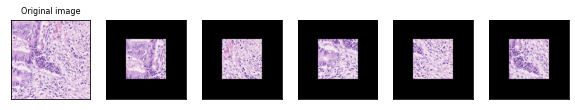

<Figure size 7200x7200 with 0 Axes>

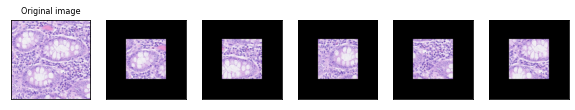

<Figure size 7200x7200 with 0 Axes>

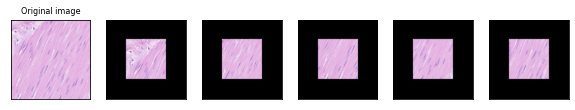

<Figure size 7200x7200 with 0 Axes>

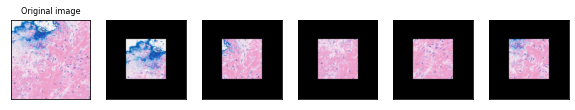

<Figure size 7200x7200 with 0 Axes>

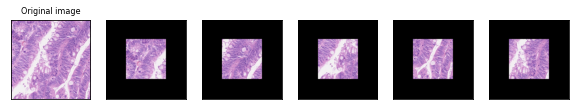

<Figure size 7200x7200 with 0 Axes>

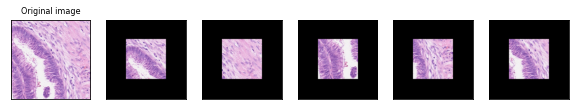

<Figure size 7200x7200 with 0 Axes>

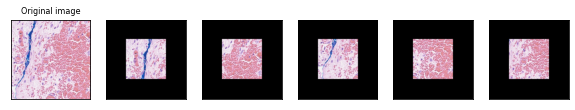

<Figure size 7200x7200 with 0 Axes>

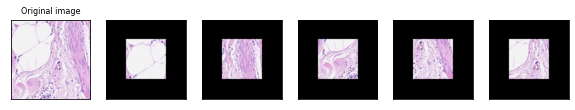

<Figure size 7200x7200 with 0 Axes>

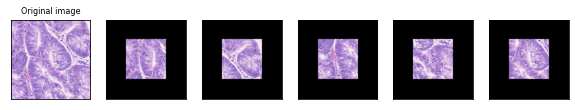

<Figure size 7200x7200 with 0 Axes>

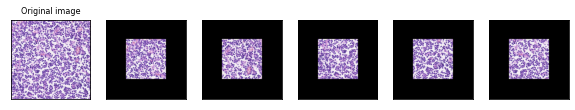

<Figure size 7200x7200 with 0 Axes>

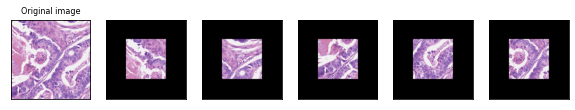

<Figure size 7200x7200 with 0 Axes>

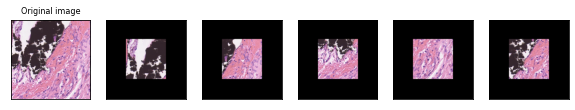

<Figure size 7200x7200 with 0 Axes>

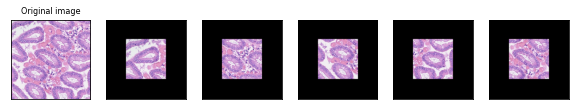

<Figure size 7200x7200 with 0 Axes>

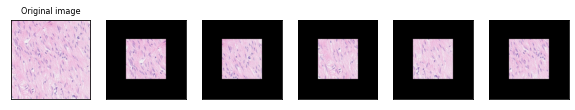

<Figure size 7200x7200 with 0 Axes>

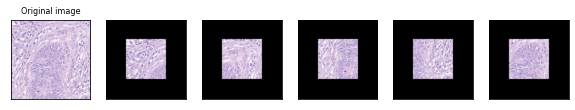

<Figure size 7200x7200 with 0 Axes>

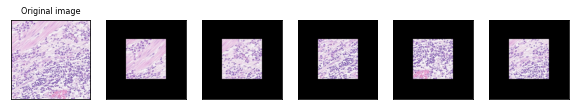

<Figure size 7200x7200 with 0 Axes>

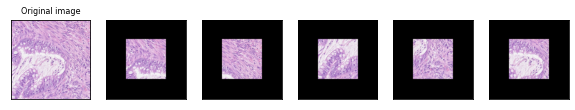

<Figure size 7200x7200 with 0 Axes>

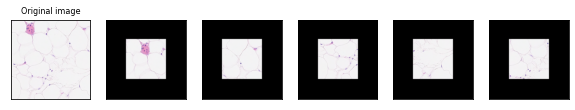

<Figure size 7200x7200 with 0 Axes>

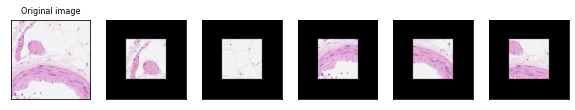

<Figure size 7200x7200 with 0 Axes>

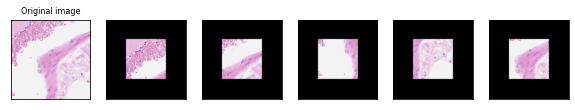

<Figure size 7200x7200 with 0 Axes>

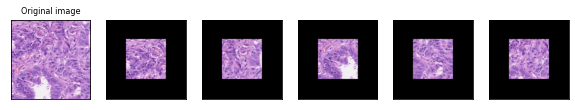

<Figure size 7200x7200 with 0 Axes>

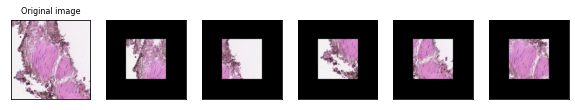

<Figure size 7200x7200 with 0 Axes>

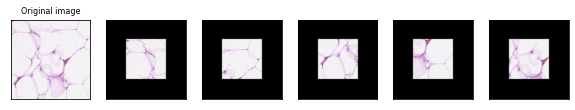

<Figure size 7200x7200 with 0 Axes>

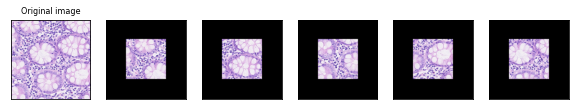

<Figure size 7200x7200 with 0 Axes>

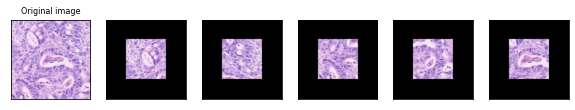

<Figure size 7200x7200 with 0 Axes>

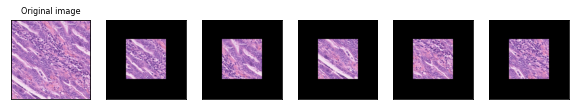

<Figure size 7200x7200 with 0 Axes>

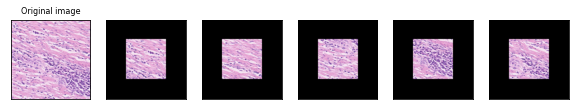

<Figure size 7200x7200 with 0 Axes>

In [73]:
%pylab inline
import torchvision.transforms as T
from torch.nn import ConstantPad2d
import numpy as np

def plot(imgs, orig_img, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(10, 10))
    fig = plt.figure(figsize=(100, 100))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def five_crop():
    root_dir = "./Train"
    fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
    img_path = "./cropped_train/Images/"
    label_path = "./cropped_train/Labels/"
    for idx in range(len(fileNames)):
        size = 500
        img_name = os.path.join(root_dir,"Images", fileNames[idx])+".png"
        mask_name = os.path.join(root_dir,"Labels", fileNames[idx])+".mat"
        dictmat = loadmat(mask_name)
        orig_img = Image.open(img_name)
        (top_left, top_right, bottom_left, bottom_right, center) = T.FiveCrop(size=(size, size))(orig_img)
        cropped = [top_left, top_right, bottom_left, bottom_right, center]
        
        orig_img.save(img_path + fileNames[idx] + "_original.png")
        savemat(label_path + fileNames[idx] + "_original.mat", {"inst_map": dictmat["inst_map"]})    
        for img_idx in range(len(cropped)):
            name = ""
            labels = {}
            if img_idx == 0:
                name = "top_left"
                labels["inst_map"] = dictmat["inst_map"][0:size, 0:size]
            elif img_idx == 1:
                name = "top_right"
                labels["inst_map"] = dictmat["inst_map"][0:size, 1000-size:1000]
            elif img_idx == 2:
                name = "bottom_left"
                labels["inst_map"] = dictmat["inst_map"][1000-size:1000, 0:size]
            elif img_idx == 3:
                name = "bottom_right"
                labels["inst_map"] = dictmat["inst_map"][1000-size:1000, 1000-size:1000]
            elif img_idx == 4:
                name = "center"
                mid_height = 1000/2
                mid_weight = 1000/2
                labels["inst_map"] = dictmat["inst_map"][round(mid_height-size/2):round(mid_height+size/2), round(mid_weight-size/2):round(mid_weight+size/2)]
            
            ## pad images and labels
            cropped[img_idx] = T.Pad(padding=250, fill=(0,0,0), padding_mode='constant')(cropped[img_idx])
            labels["inst_map"] = np.pad(labels["inst_map"], 1, pad_with, padder=0)
            ## save 
            cropped[img_idx].save(img_path + fileNames[idx] + "_" +name+".png")            
            savemat(label_path + fileNames[idx] + "_" +name+".mat", labels)           
        plot(cropped, orig_img)
#         if idx == 0:        
#             break
    
five_crop()

In [51]:
before = "./Train/Labels/train_1.mat"
after = "./cropped_train/Labels/train_1_original.mat"

dictmat_before = loadmat(before)
dictmat_after = loadmat(after)
print(dictmat_before["inst_map"] == dictmat_after["inst_map"])

a = np.arange(6)
a = a.reshape((2, 3))
print(a)
pad = np.pad(a, 2, pad_with, padder=100)
print(pad)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [2]:
class CellDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fileNames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,"Images",self.fileNames[idx])+".png"
        image = img = Image.open(img_name).convert('RGB')
        mask_name = os.path.join(self.root_dir,"Labels",self.fileNames[idx])+".mat"
        mask = np.pad((loadmat(mask_name)['inst_map']>=1).astype(int),12)
        if self.transform:
            image = self.transform(image)

        return image, mask

In [3]:
transform = transforms.Compose([
    transforms.Pad(12),
    transforms.ToTensor()    
])

# DataLoader
train_ds = CellDataset(root_dir="./Train", transform = transform)
train_dataloader = DataLoader(train_ds, batch_size=1, shuffle=False)

test_ds = CellDataset(root_dir="./Test", transform = transform)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=False)

## Training

In [4]:
def weighted_loss(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)

    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss

def train(model, device, train_loader, optimizer, epochs):
    """
    Trains the model on training data
    """
    
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
            
        for batch_idx, (data, target) in enumerate(train_loader):
            model.train()
            data, target = data.to(device), target.to(device).float()

            optimizer.zero_grad()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.3)
            loss.backward()
            optimizer.step()

            train_loss+=(loss/len(data)).item()
            # Find accuracy

        train_loss /= len(train_loader)

        print('Train Epoch: {} @ {} - Train Loss: {:.4f}'.format(epoch, datetime.datetime.now().time(), train_loss))
#         print("Predicted Mask Sigmoid")
#         plt.imshow(output.to('cpu').detach().numpy()[0][0],cmap='gray')
#         plt.show()
#         print("Actual Mask")
#         plt.imshow(target.to('cpu').detach()[0],cmap='gray')
#         plt.show()

In [5]:
# Set cpu / gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = build_model(device)
model.to(device)

ResNet_Attention_UNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 1 @ 12:11:51.010240 - Train Loss: 0.5953
Predicted Mask Sigmoid


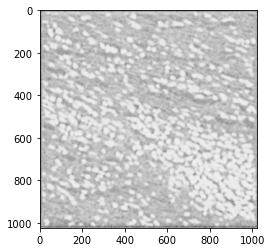

Actual Mask


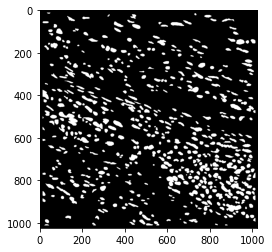

  3%|▎         | 1/30 [00:08<04:06,  8.51s/it]

Train Epoch: 2 @ 12:11:58.808098 - Train Loss: 0.4272
Predicted Mask Sigmoid


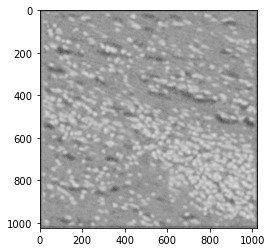

Actual Mask


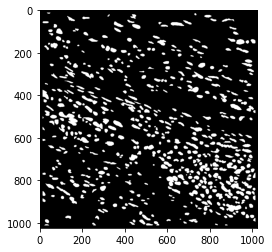

  7%|▋         | 2/30 [00:16<03:52,  8.29s/it]

Train Epoch: 3 @ 12:12:06.544229 - Train Loss: 0.3664
Predicted Mask Sigmoid


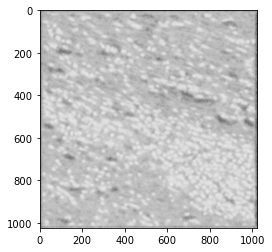

Actual Mask


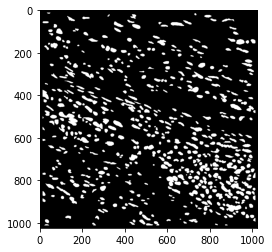

 10%|█         | 3/30 [00:24<03:39,  8.13s/it]

Train Epoch: 4 @ 12:12:14.321687 - Train Loss: 0.3115
Predicted Mask Sigmoid


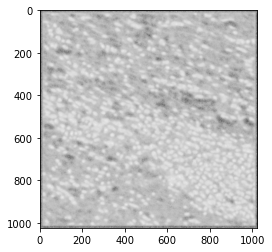

Actual Mask


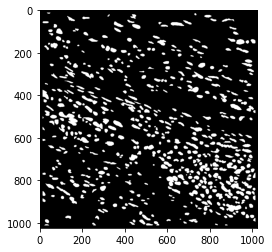

 13%|█▎        | 4/30 [00:31<03:28,  8.04s/it]

Train Epoch: 5 @ 12:12:22.192737 - Train Loss: 0.2952
Predicted Mask Sigmoid


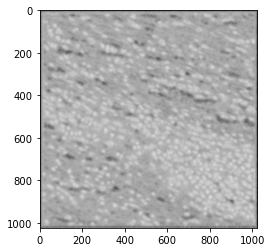

Actual Mask


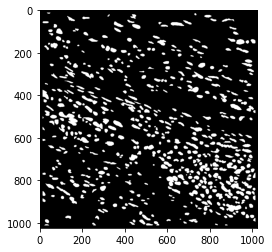

 17%|█▋        | 5/30 [00:39<03:19,  7.98s/it]

Train Epoch: 6 @ 12:12:29.888479 - Train Loss: 0.2732
Predicted Mask Sigmoid


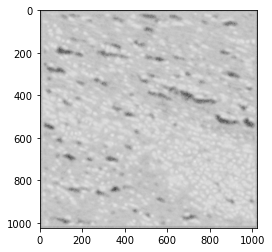

Actual Mask


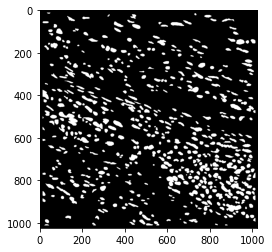

 20%|██        | 6/30 [00:47<03:09,  7.88s/it]

Train Epoch: 7 @ 12:12:37.607727 - Train Loss: 0.2701
Predicted Mask Sigmoid


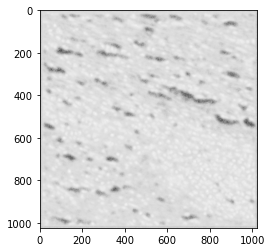

Actual Mask


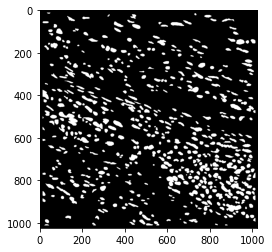

 23%|██▎       | 7/30 [00:55<03:00,  7.84s/it]

Train Epoch: 8 @ 12:12:45.429590 - Train Loss: 0.2720
Predicted Mask Sigmoid


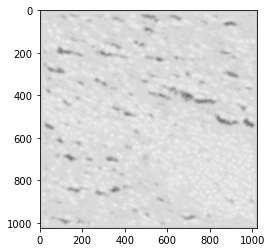

Actual Mask


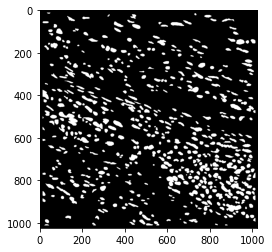

 27%|██▋       | 8/30 [01:02<02:52,  7.83s/it]

Train Epoch: 9 @ 12:12:53.293813 - Train Loss: 0.2433
Predicted Mask Sigmoid


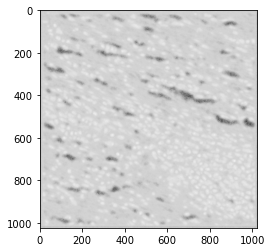

Actual Mask


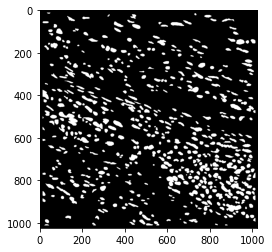

 30%|███       | 9/30 [01:10<02:44,  7.85s/it]

Train Epoch: 10 @ 12:13:01.029696 - Train Loss: 0.2272
Predicted Mask Sigmoid


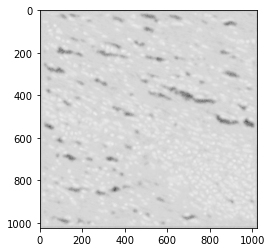

Actual Mask


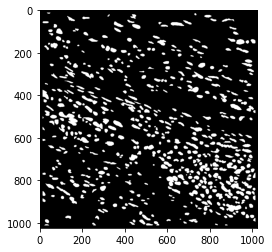

 33%|███▎      | 10/30 [01:18<02:36,  7.81s/it]

Train Epoch: 11 @ 12:13:08.766052 - Train Loss: 0.2171
Predicted Mask Sigmoid


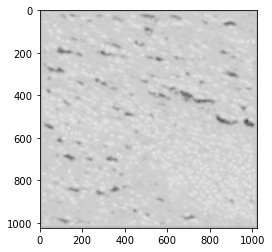

Actual Mask


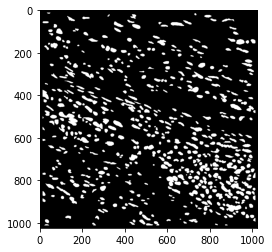

 37%|███▋      | 11/30 [01:26<02:28,  7.80s/it]

Train Epoch: 12 @ 12:13:16.568814 - Train Loss: 0.2034
Predicted Mask Sigmoid


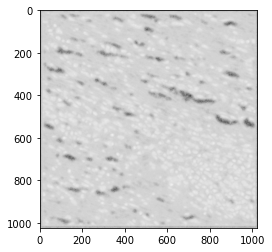

Actual Mask


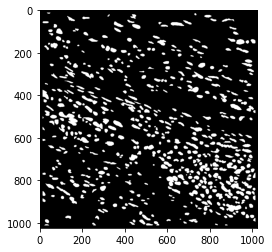

 40%|████      | 12/30 [01:34<02:20,  7.79s/it]

Train Epoch: 13 @ 12:13:24.281660 - Train Loss: 0.1955
Predicted Mask Sigmoid


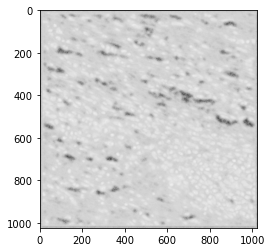

Actual Mask


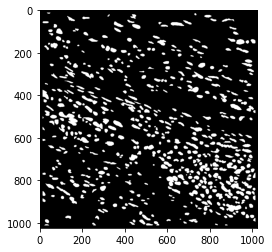

 43%|████▎     | 13/30 [01:41<02:11,  7.76s/it]

Train Epoch: 14 @ 12:13:31.945819 - Train Loss: 0.2029
Predicted Mask Sigmoid


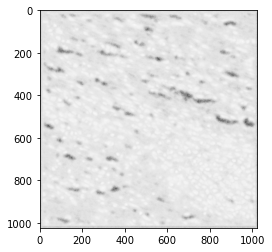

Actual Mask


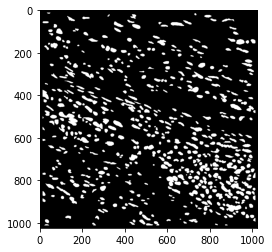

 47%|████▋     | 14/30 [01:49<02:03,  7.73s/it]

Train Epoch: 15 @ 12:13:39.724288 - Train Loss: 0.2264
Predicted Mask Sigmoid


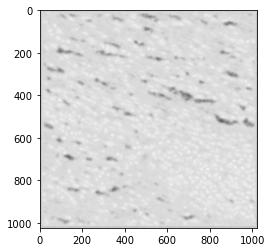

Actual Mask


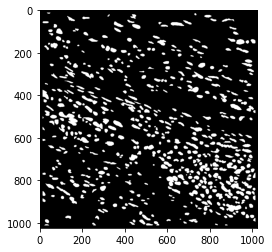

 50%|█████     | 15/30 [01:57<01:56,  7.75s/it]

Train Epoch: 16 @ 12:13:47.408570 - Train Loss: 0.2212
Predicted Mask Sigmoid


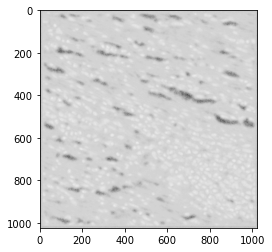

Actual Mask


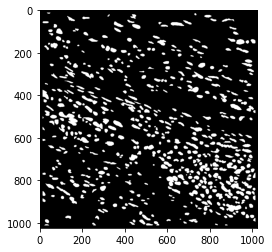

 53%|█████▎    | 16/30 [02:04<01:48,  7.73s/it]

Train Epoch: 17 @ 12:13:55.050575 - Train Loss: 0.2021
Predicted Mask Sigmoid


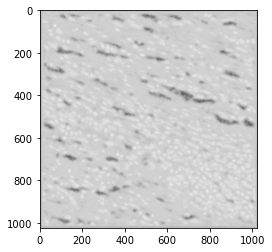

Actual Mask


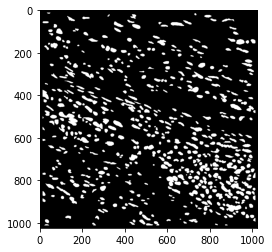

 57%|█████▋    | 17/30 [02:12<01:40,  7.70s/it]

Train Epoch: 18 @ 12:14:02.745603 - Train Loss: 0.1954
Predicted Mask Sigmoid


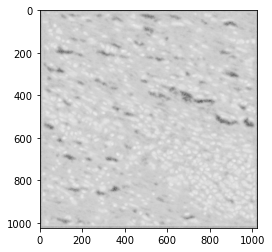

Actual Mask


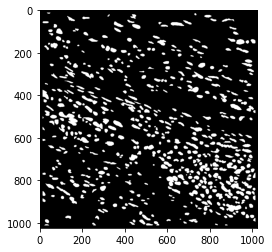

 60%|██████    | 18/30 [02:20<01:32,  7.72s/it]

Train Epoch: 19 @ 12:14:10.459028 - Train Loss: 0.1851
Predicted Mask Sigmoid


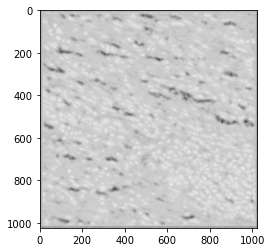

Actual Mask


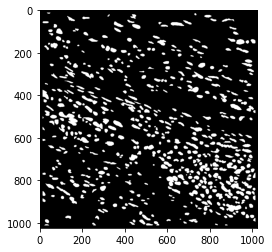

 63%|██████▎   | 19/30 [02:27<01:24,  7.70s/it]

Train Epoch: 20 @ 12:14:18.156048 - Train Loss: 0.1802
Predicted Mask Sigmoid


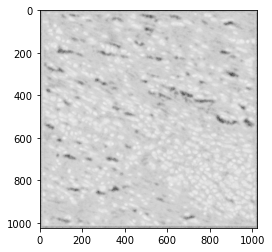

Actual Mask


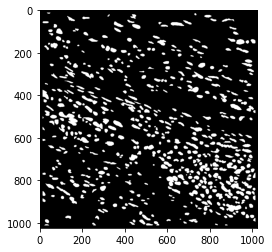

 67%|██████▋   | 20/30 [02:35<01:16,  7.70s/it]

Train Epoch: 21 @ 12:14:25.895265 - Train Loss: 0.1797
Predicted Mask Sigmoid


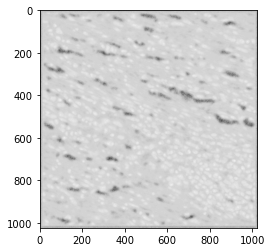

Actual Mask


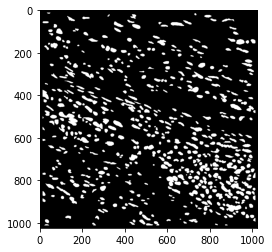

 70%|███████   | 21/30 [02:43<01:09,  7.71s/it]

Train Epoch: 22 @ 12:14:33.596896 - Train Loss: 0.1827
Predicted Mask Sigmoid


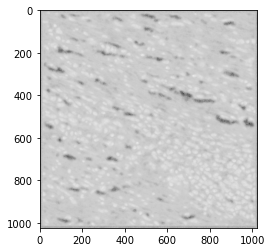

Actual Mask


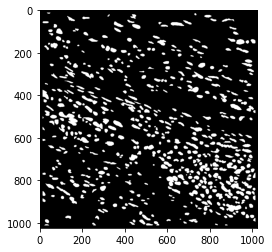

 73%|███████▎  | 22/30 [02:51<01:01,  7.71s/it]

Train Epoch: 23 @ 12:14:41.343199 - Train Loss: 0.1708
Predicted Mask Sigmoid


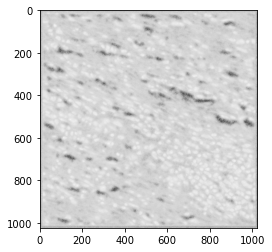

Actual Mask


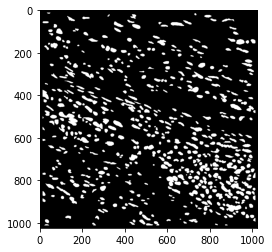

 77%|███████▋  | 23/30 [02:58<00:54,  7.72s/it]

Train Epoch: 24 @ 12:14:49.069505 - Train Loss: 0.1705
Predicted Mask Sigmoid


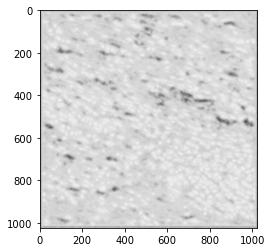

Actual Mask


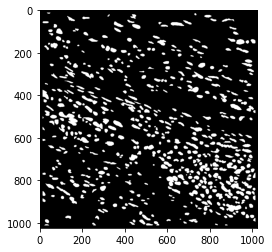

 80%|████████  | 24/30 [03:06<00:46,  7.72s/it]

Train Epoch: 25 @ 12:14:56.804939 - Train Loss: 0.1744
Predicted Mask Sigmoid


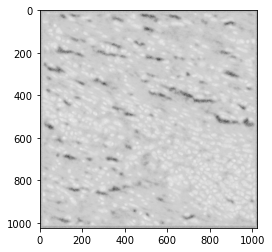

Actual Mask


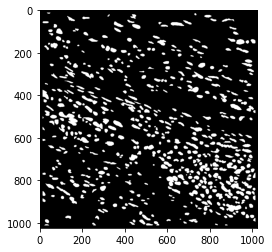

 83%|████████▎ | 25/30 [03:14<00:38,  7.74s/it]

Train Epoch: 26 @ 12:15:04.556473 - Train Loss: 0.1731
Predicted Mask Sigmoid


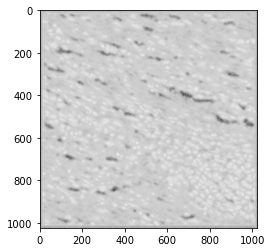

Actual Mask


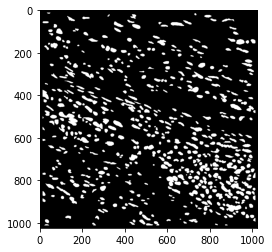

 87%|████████▋ | 26/30 [03:22<00:30,  7.73s/it]

Train Epoch: 27 @ 12:15:12.274025 - Train Loss: 0.1630
Predicted Mask Sigmoid


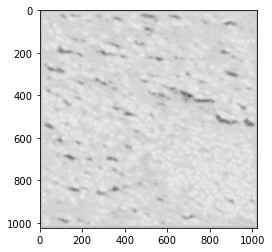

Actual Mask


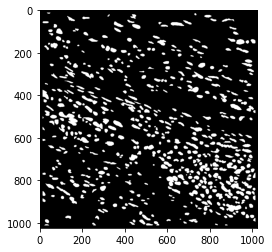

 90%|█████████ | 27/30 [03:29<00:23,  7.73s/it]

Train Epoch: 28 @ 12:15:19.968874 - Train Loss: 0.1632
Predicted Mask Sigmoid


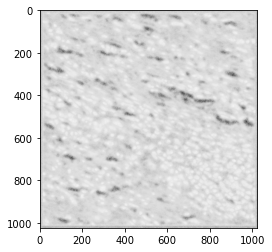

Actual Mask


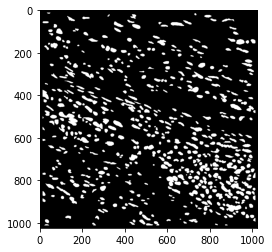

 93%|█████████▎| 28/30 [03:37<00:15,  7.72s/it]

Train Epoch: 29 @ 12:15:27.554567 - Train Loss: 0.1654
Predicted Mask Sigmoid


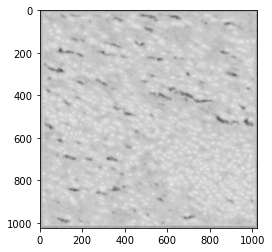

Actual Mask


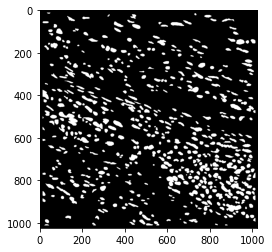

 97%|█████████▋| 29/30 [03:45<00:07,  7.68s/it]

Train Epoch: 30 @ 12:15:35.167519 - Train Loss: 0.1676
Predicted Mask Sigmoid


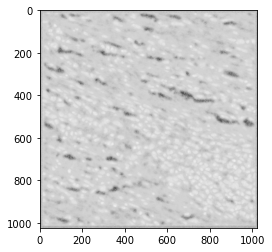

Actual Mask


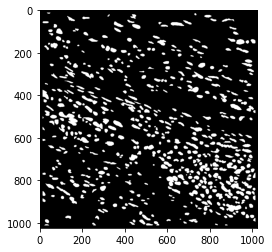

100%|██████████| 30/30 [03:52<00:00,  7.75s/it]


In [6]:
# Training the model
epochs = 30
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

train(model, device, train_dataloader, optimizer, epochs)

## Testing

In [5]:
def test(model, device, test_loader):
    iou_scores = []

    for data, target in test_loader:
        print("Input Image")
        plt.imshow(data[0].numpy().transpose(1, 2, 0))
        plt.show()
        outputs = model(data.to(device))
        pred = outputs.to('cpu').detach().numpy()[0][0]

        print("Predicted Mask Sigmoid")
        plt.imshow(pred,cmap='gray')
        plt.show()
        threshold=0.95
        pred[pred >= threshold] = 1
        pred[pred < threshold] = 0
        print("Predicted Mask Binary")
        plt.imshow(pred,cmap='gray')
        plt.show()
        print("Actual Mask")
        plt.imshow(target[0],cmap='gray')
        plt.show()

        # iou
        target_ts = target[0].to('cpu').detach().numpy()
        intersection = np.logical_and(target_ts, pred)
        union = np.logical_or(target_ts, pred)
        iou_score = np.sum(intersection) / np.sum(union)
        print(iou_score, "\n")

        iou_scores.append(iou_score)

        break

    # print(sum(iou_scores)/len(iou_scores))

Input Image


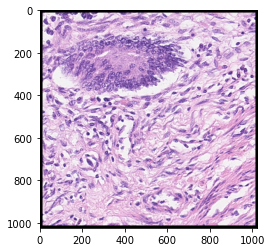

Predicted Mask Sigmoid


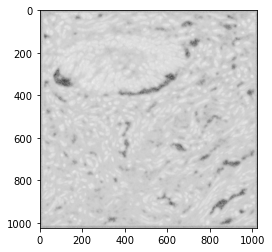

Predicted Mask Binary


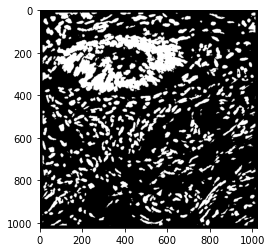

Actual Mask


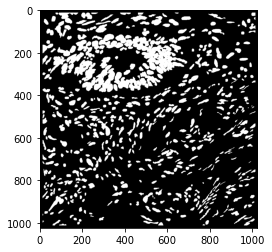

0.693348825408965


In [8]:
# Testing the model
test(model, device, test_dataloader)

## Hyperparameter Tuning

In [6]:
def hyperparam_tuning(bs, lr, epochs):
    print("Batch size: {}, Learning rate: {} , Epochs: {}\n".format(bs, lr, epochs))
    
    # DataLoader
    train_ds = CellDataset(root_dir="./Train", transform = transform)
    train_dataloader = DataLoader(train_ds, batch_size=bs, shuffle=False)

    test_ds = CellDataset(root_dir="./Test", transform = transform)
    test_dataloader = DataLoader(test_ds, batch_size=bs, shuffle=False)
    
    # Set cpu / gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model and optimizer
    model = build_model(device)
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    
    # Train model
    train(model, device, train_dataloader, optimizer, epochs)
    
    # Test model
    test(model, device, test_dataloader)

Batch size: 1, Learning rate: 0.001 , Epochs: 20



  5%|▌         | 1/20 [00:07<02:31,  7.97s/it]

Train Epoch: 1 @ 15:12:01.144423 - Train Loss: 0.6318


 10%|█         | 2/20 [00:15<02:21,  7.84s/it]

Train Epoch: 2 @ 15:12:08.674345 - Train Loss: 0.4574


 15%|█▌        | 3/20 [00:23<02:11,  7.75s/it]

Train Epoch: 3 @ 15:12:16.201103 - Train Loss: 0.3816


 20%|██        | 4/20 [00:30<02:02,  7.65s/it]

Train Epoch: 4 @ 15:12:23.633035 - Train Loss: 0.3305


 25%|██▌       | 5/20 [00:37<01:53,  7.60s/it]

Train Epoch: 5 @ 15:12:31.100936 - Train Loss: 0.3043


 30%|███       | 6/20 [00:45<01:45,  7.55s/it]

Train Epoch: 6 @ 15:12:38.545900 - Train Loss: 0.2741


 35%|███▌      | 7/20 [00:52<01:37,  7.52s/it]

Train Epoch: 7 @ 15:12:45.994836 - Train Loss: 0.2774


 40%|████      | 8/20 [01:00<01:30,  7.51s/it]

Train Epoch: 8 @ 15:12:53.489304 - Train Loss: 0.2662


 45%|████▌     | 9/20 [01:07<01:22,  7.50s/it]

Train Epoch: 9 @ 15:13:00.956716 - Train Loss: 0.2663


 50%|█████     | 10/20 [01:15<01:15,  7.50s/it]

Train Epoch: 10 @ 15:13:08.467691 - Train Loss: 0.2287


 55%|█████▌    | 11/20 [01:22<01:07,  7.48s/it]

Train Epoch: 11 @ 15:13:15.905308 - Train Loss: 0.2226


 60%|██████    | 12/20 [01:30<00:59,  7.47s/it]

Train Epoch: 12 @ 15:13:23.344829 - Train Loss: 0.2234


 65%|██████▌   | 13/20 [01:37<00:52,  7.52s/it]

Train Epoch: 13 @ 15:13:30.977423 - Train Loss: 0.2075


 70%|███████   | 14/20 [01:45<00:45,  7.51s/it]

Train Epoch: 14 @ 15:13:38.458458 - Train Loss: 0.2031


 75%|███████▌  | 15/20 [01:52<00:37,  7.50s/it]

Train Epoch: 15 @ 15:13:45.939818 - Train Loss: 0.1995


 80%|████████  | 16/20 [02:00<00:29,  7.46s/it]

Train Epoch: 16 @ 15:13:53.320048 - Train Loss: 0.1955


 85%|████████▌ | 17/20 [02:07<00:22,  7.47s/it]

Train Epoch: 17 @ 15:14:00.820944 - Train Loss: 0.1968


 90%|█████████ | 18/20 [02:15<00:14,  7.47s/it]

Train Epoch: 18 @ 15:14:08.271120 - Train Loss: 0.2149


 95%|█████████▌| 19/20 [02:22<00:07,  7.48s/it]

Train Epoch: 19 @ 15:14:15.788890 - Train Loss: 0.2017


100%|██████████| 20/20 [02:30<00:00,  7.51s/it]

Train Epoch: 20 @ 15:14:23.323385 - Train Loss: 0.1951
Input Image


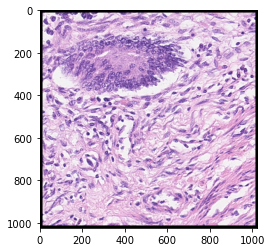

Predicted Mask Sigmoid


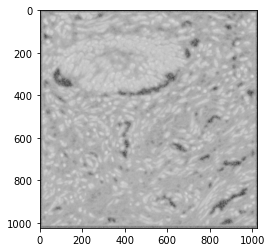

Predicted Mask Binary


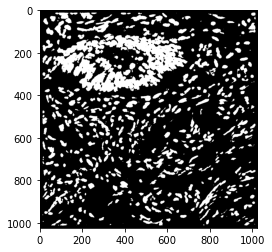

Actual Mask


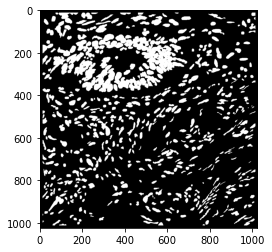

0.6916254211599895 

Batch size: 1, Learning rate: 0.001 , Epochs: 30



  3%|▎         | 1/30 [00:07<03:33,  7.37s/it]

Train Epoch: 1 @ 15:14:32.034175 - Train Loss: 0.6147


  7%|▋         | 2/30 [00:14<03:26,  7.39s/it]

Train Epoch: 2 @ 15:14:39.468794 - Train Loss: 0.4362


 10%|█         | 3/30 [00:22<03:19,  7.37s/it]

Train Epoch: 3 @ 15:14:46.793249 - Train Loss: 0.3552


 13%|█▎        | 4/30 [00:29<03:12,  7.42s/it]

Train Epoch: 4 @ 15:14:54.331919 - Train Loss: 0.3137


 17%|█▋        | 5/30 [00:37<03:05,  7.42s/it]

Train Epoch: 5 @ 15:15:01.736197 - Train Loss: 0.2793


 20%|██        | 6/30 [00:44<02:58,  7.43s/it]

Train Epoch: 6 @ 15:15:09.192024 - Train Loss: 0.2840


 23%|██▎       | 7/30 [00:51<02:50,  7.41s/it]

Train Epoch: 7 @ 15:15:16.554727 - Train Loss: 0.2771


 27%|██▋       | 8/30 [00:59<02:43,  7.43s/it]

Train Epoch: 8 @ 15:15:24.035322 - Train Loss: 0.2546


 30%|███       | 9/30 [01:06<02:35,  7.42s/it]

Train Epoch: 9 @ 15:15:31.418293 - Train Loss: 0.2205


 33%|███▎      | 10/30 [01:14<02:28,  7.44s/it]

Train Epoch: 10 @ 15:15:38.925358 - Train Loss: 0.2126


 37%|███▋      | 11/30 [01:21<02:21,  7.47s/it]

Train Epoch: 11 @ 15:15:46.446332 - Train Loss: 0.2131


 40%|████      | 12/30 [01:29<02:14,  7.48s/it]

Train Epoch: 12 @ 15:15:53.966352 - Train Loss: 0.2172


 43%|████▎     | 13/30 [01:36<02:06,  7.47s/it]

Train Epoch: 13 @ 15:16:01.398763 - Train Loss: 0.2065


 47%|████▋     | 14/30 [01:44<01:59,  7.49s/it]

Train Epoch: 14 @ 15:16:08.931990 - Train Loss: 0.1956


 50%|█████     | 15/30 [01:51<01:52,  7.49s/it]

Train Epoch: 15 @ 15:16:16.416449 - Train Loss: 0.2031


 53%|█████▎    | 16/30 [01:59<01:44,  7.50s/it]

Train Epoch: 16 @ 15:16:23.943414 - Train Loss: 0.1960


 57%|█████▋    | 17/30 [02:06<01:36,  7.45s/it]

Train Epoch: 17 @ 15:16:31.292902 - Train Loss: 0.1951


 60%|██████    | 18/30 [02:14<01:29,  7.46s/it]

Train Epoch: 18 @ 15:16:38.778060 - Train Loss: 0.1909


 63%|██████▎   | 19/30 [02:21<01:21,  7.45s/it]

Train Epoch: 19 @ 15:16:46.184690 - Train Loss: 0.1809


 67%|██████▋   | 20/30 [02:29<01:14,  7.48s/it]

Train Epoch: 20 @ 15:16:53.757176 - Train Loss: 0.1775


 70%|███████   | 21/30 [02:36<01:07,  7.50s/it]

Train Epoch: 21 @ 15:17:01.284608 - Train Loss: 0.1905


 73%|███████▎  | 22/30 [02:44<01:00,  7.53s/it]

Train Epoch: 22 @ 15:17:08.903123 - Train Loss: 0.1951


 77%|███████▋  | 23/30 [02:51<00:52,  7.49s/it]

Train Epoch: 23 @ 15:17:16.278005 - Train Loss: 0.2081


 80%|████████  | 24/30 [02:59<00:44,  7.48s/it]

Train Epoch: 24 @ 15:17:23.760711 - Train Loss: 0.1992


 83%|████████▎ | 25/30 [03:06<00:37,  7.47s/it]

Train Epoch: 25 @ 15:17:31.186401 - Train Loss: 0.1690


 87%|████████▋ | 26/30 [03:14<00:29,  7.49s/it]

Train Epoch: 26 @ 15:17:38.717092 - Train Loss: 0.1573


 90%|█████████ | 27/30 [03:21<00:22,  7.48s/it]

Train Epoch: 27 @ 15:17:46.196192 - Train Loss: 0.1516


 93%|█████████▎| 28/30 [03:29<00:14,  7.49s/it]

Train Epoch: 28 @ 15:17:53.685648 - Train Loss: 0.1509


 97%|█████████▋| 29/30 [03:36<00:07,  7.48s/it]

Train Epoch: 29 @ 15:18:01.137566 - Train Loss: 0.1628


100%|██████████| 30/30 [03:43<00:00,  7.47s/it]

Train Epoch: 30 @ 15:18:08.647592 - Train Loss: 0.1557
Input Image


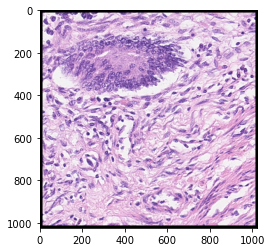

Predicted Mask Sigmoid


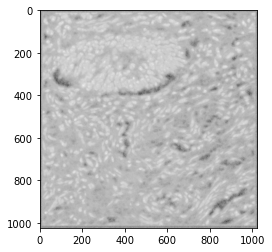

Predicted Mask Binary


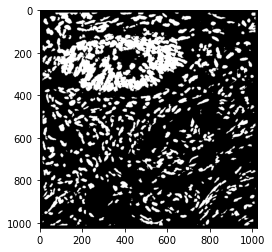

Actual Mask


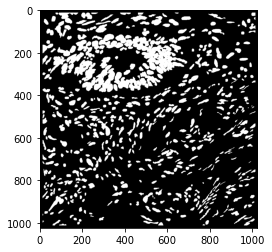

0.6949769165259745 

Batch size: 1, Learning rate: 0.001 , Epochs: 40



  2%|▎         | 1/40 [00:07<04:45,  7.31s/it]

Train Epoch: 1 @ 15:18:17.383768 - Train Loss: 0.6203


  5%|▌         | 2/40 [00:14<04:37,  7.31s/it]

Train Epoch: 2 @ 15:18:24.706926 - Train Loss: 0.4328


  8%|▊         | 3/40 [00:21<04:30,  7.31s/it]

Train Epoch: 3 @ 15:18:32.000077 - Train Loss: 0.3618


 10%|█         | 4/40 [00:29<04:22,  7.30s/it]

Train Epoch: 4 @ 15:18:39.289859 - Train Loss: 0.3205


 12%|█▎        | 5/40 [00:36<04:16,  7.31s/it]

Train Epoch: 5 @ 15:18:46.633610 - Train Loss: 0.2884


 15%|█▌        | 6/40 [00:43<04:09,  7.33s/it]

Train Epoch: 6 @ 15:18:54.001637 - Train Loss: 0.2869


 18%|█▊        | 7/40 [00:51<04:01,  7.32s/it]

Train Epoch: 7 @ 15:19:01.293404 - Train Loss: 0.2672


 20%|██        | 8/40 [00:58<03:54,  7.33s/it]

Train Epoch: 8 @ 15:19:08.639078 - Train Loss: 0.2725


 22%|██▎       | 9/40 [01:05<03:47,  7.33s/it]

Train Epoch: 9 @ 15:19:15.975669 - Train Loss: 0.2487


 25%|██▌       | 10/40 [01:13<03:39,  7.33s/it]

Train Epoch: 10 @ 15:19:23.300978 - Train Loss: 0.2213


 28%|██▊       | 11/40 [01:20<03:32,  7.32s/it]

Train Epoch: 11 @ 15:19:30.590813 - Train Loss: 0.2271


 30%|███       | 12/40 [01:27<03:25,  7.34s/it]

Train Epoch: 12 @ 15:19:37.971523 - Train Loss: 0.2230


 32%|███▎      | 13/40 [01:35<03:17,  7.32s/it]

Train Epoch: 13 @ 15:19:45.259849 - Train Loss: 0.2055


 35%|███▌      | 14/40 [01:42<03:10,  7.33s/it]

Train Epoch: 14 @ 15:19:52.617255 - Train Loss: 0.2006


 38%|███▊      | 15/40 [01:49<03:03,  7.32s/it]

Train Epoch: 15 @ 15:19:59.909009 - Train Loss: 0.2003


 40%|████      | 16/40 [01:57<02:55,  7.31s/it]

Train Epoch: 16 @ 15:20:07.206553 - Train Loss: 0.2101


 42%|████▎     | 17/40 [02:04<02:47,  7.30s/it]

Train Epoch: 17 @ 15:20:14.466574 - Train Loss: 0.2108


 45%|████▌     | 18/40 [02:11<02:40,  7.30s/it]

Train Epoch: 18 @ 15:20:21.780592 - Train Loss: 0.1942


 48%|████▊     | 19/40 [02:19<02:33,  7.31s/it]

Train Epoch: 19 @ 15:20:29.106324 - Train Loss: 0.1898


 50%|█████     | 20/40 [02:26<02:26,  7.32s/it]

Train Epoch: 20 @ 15:20:36.454691 - Train Loss: 0.1788


 52%|█████▎    | 21/40 [02:33<02:18,  7.30s/it]

Train Epoch: 21 @ 15:20:43.716671 - Train Loss: 0.1792


 55%|█████▌    | 22/40 [02:41<02:11,  7.32s/it]

Train Epoch: 22 @ 15:20:51.085296 - Train Loss: 0.1808


 57%|█████▊    | 23/40 [02:48<02:04,  7.32s/it]

Train Epoch: 23 @ 15:20:58.386769 - Train Loss: 0.1805


 60%|██████    | 24/40 [02:55<01:57,  7.34s/it]

Train Epoch: 24 @ 15:21:05.770187 - Train Loss: 0.1831


 62%|██████▎   | 25/40 [03:02<01:49,  7.32s/it]

Train Epoch: 25 @ 15:21:13.054171 - Train Loss: 0.1693


 65%|██████▌   | 26/40 [03:10<01:42,  7.31s/it]

Train Epoch: 26 @ 15:21:20.355065 - Train Loss: 0.1596


 68%|██████▊   | 27/40 [03:17<01:35,  7.32s/it]

Train Epoch: 27 @ 15:21:27.701628 - Train Loss: 0.1611


 70%|███████   | 28/40 [03:24<01:27,  7.32s/it]

Train Epoch: 28 @ 15:21:35.015033 - Train Loss: 0.1567


 72%|███████▎  | 29/40 [03:32<01:20,  7.34s/it]

Train Epoch: 29 @ 15:21:42.390340 - Train Loss: 0.1665


 75%|███████▌  | 30/40 [03:39<01:13,  7.35s/it]

Train Epoch: 30 @ 15:21:49.784283 - Train Loss: 0.1755


 78%|███████▊  | 31/40 [03:46<01:05,  7.33s/it]

Train Epoch: 31 @ 15:21:57.057654 - Train Loss: 0.1634


 80%|████████  | 32/40 [03:54<00:58,  7.33s/it]

Train Epoch: 32 @ 15:22:04.384237 - Train Loss: 0.1563


 82%|████████▎ | 33/40 [04:01<00:51,  7.32s/it]

Train Epoch: 33 @ 15:22:11.669307 - Train Loss: 0.1481


 85%|████████▌ | 34/40 [04:08<00:43,  7.30s/it]

Train Epoch: 34 @ 15:22:18.948569 - Train Loss: 0.1722


 88%|████████▊ | 35/40 [04:16<00:36,  7.30s/it]

Train Epoch: 35 @ 15:22:26.253679 - Train Loss: 0.1709


 90%|█████████ | 36/40 [04:23<00:29,  7.31s/it]

Train Epoch: 36 @ 15:22:33.567299 - Train Loss: 0.1524


 92%|█████████▎| 37/40 [04:30<00:21,  7.32s/it]

Train Epoch: 37 @ 15:22:40.917404 - Train Loss: 0.1420


 95%|█████████▌| 38/40 [04:38<00:14,  7.32s/it]

Train Epoch: 38 @ 15:22:48.237797 - Train Loss: 0.1412


 98%|█████████▊| 39/40 [04:45<00:07,  7.33s/it]

Train Epoch: 39 @ 15:22:55.597290 - Train Loss: 0.1413


100%|██████████| 40/40 [04:52<00:00,  7.32s/it]

Train Epoch: 40 @ 15:23:02.889595 - Train Loss: 0.1517
Input Image


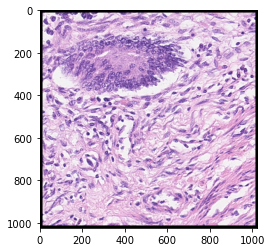

Predicted Mask Sigmoid


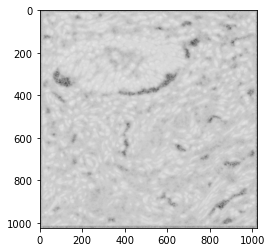

Predicted Mask Binary


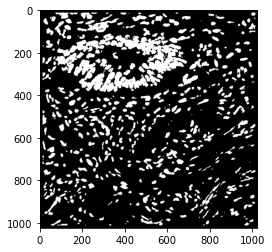

Actual Mask


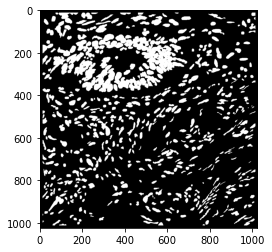

0.6749952988905382 

Batch size: 1, Learning rate: 0.0001 , Epochs: 20



  5%|▌         | 1/20 [00:07<02:23,  7.55s/it]

Train Epoch: 1 @ 15:23:11.764964 - Train Loss: 0.6883


 10%|█         | 2/20 [00:15<02:15,  7.53s/it]

Train Epoch: 2 @ 15:23:19.261186 - Train Loss: 0.5308


 15%|█▌        | 3/20 [00:22<02:08,  7.55s/it]

Train Epoch: 3 @ 15:23:26.855921 - Train Loss: 0.4066


 20%|██        | 4/20 [00:30<02:01,  7.57s/it]

Train Epoch: 4 @ 15:23:34.462889 - Train Loss: 0.3450


 25%|██▌       | 5/20 [00:37<01:53,  7.56s/it]

Train Epoch: 5 @ 15:23:42.016258 - Train Loss: 0.3097


 30%|███       | 6/20 [00:45<01:46,  7.57s/it]

Train Epoch: 6 @ 15:23:49.610709 - Train Loss: 0.2902


 35%|███▌      | 7/20 [00:52<01:38,  7.56s/it]

Train Epoch: 7 @ 15:23:57.139304 - Train Loss: 0.2775


 40%|████      | 8/20 [01:00<01:30,  7.57s/it]

Train Epoch: 8 @ 15:24:04.747713 - Train Loss: 0.2683


 45%|████▌     | 9/20 [01:08<01:23,  7.57s/it]

Train Epoch: 9 @ 15:24:12.310236 - Train Loss: 0.2645


 50%|█████     | 10/20 [01:15<01:15,  7.57s/it]

Train Epoch: 10 @ 15:24:19.888400 - Train Loss: 0.2439


 55%|█████▌    | 11/20 [01:23<01:08,  7.57s/it]

Train Epoch: 11 @ 15:24:27.458456 - Train Loss: 0.2354


 60%|██████    | 12/20 [01:30<01:00,  7.59s/it]

Train Epoch: 12 @ 15:24:35.079726 - Train Loss: 0.2287


 65%|██████▌   | 13/20 [01:38<00:52,  7.56s/it]

Train Epoch: 13 @ 15:24:42.572666 - Train Loss: 0.2210


 70%|███████   | 14/20 [01:45<00:45,  7.55s/it]

Train Epoch: 14 @ 15:24:50.113362 - Train Loss: 0.2157


 75%|███████▌  | 15/20 [01:53<00:37,  7.58s/it]

Train Epoch: 15 @ 15:24:57.744164 - Train Loss: 0.2111


 80%|████████  | 16/20 [02:01<00:30,  7.60s/it]

Train Epoch: 16 @ 15:25:05.399931 - Train Loss: 0.2069


 85%|████████▌ | 17/20 [02:08<00:22,  7.60s/it]

Train Epoch: 17 @ 15:25:12.991940 - Train Loss: 0.2197


 90%|█████████ | 18/20 [02:16<00:15,  7.58s/it]

Train Epoch: 18 @ 15:25:20.538732 - Train Loss: 0.2223


 95%|█████████▌| 19/20 [02:23<00:07,  7.59s/it]

Train Epoch: 19 @ 15:25:28.147751 - Train Loss: 0.2143


100%|██████████| 20/20 [02:31<00:00,  7.58s/it]

Train Epoch: 20 @ 15:25:35.793236 - Train Loss: 0.1983
Input Image


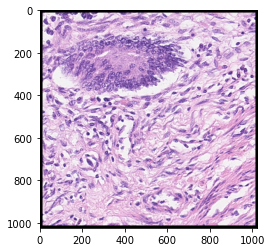

Predicted Mask Sigmoid


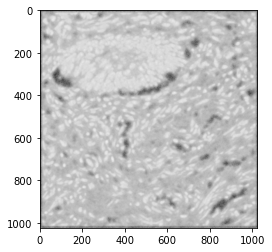

Predicted Mask Binary


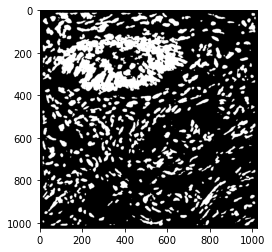

Actual Mask


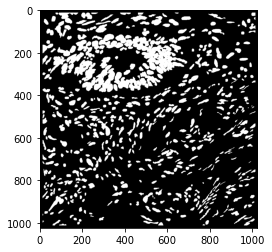

0.6801822706360836 

Batch size: 1, Learning rate: 0.0001 , Epochs: 30



  3%|▎         | 1/30 [00:07<03:40,  7.60s/it]

Train Epoch: 1 @ 15:25:44.810322 - Train Loss: 0.6765


  7%|▋         | 2/30 [00:15<03:32,  7.58s/it]

Train Epoch: 2 @ 15:25:52.359370 - Train Loss: 0.5001


 10%|█         | 3/30 [00:22<03:25,  7.60s/it]

Train Epoch: 3 @ 15:26:00.016630 - Train Loss: 0.3835


 13%|█▎        | 4/30 [00:30<03:17,  7.60s/it]

Train Epoch: 4 @ 15:26:07.603536 - Train Loss: 0.3372


 17%|█▋        | 5/30 [00:37<03:09,  7.59s/it]

Train Epoch: 5 @ 15:26:15.174497 - Train Loss: 0.3098


 20%|██        | 6/30 [00:45<03:01,  7.57s/it]

Train Epoch: 6 @ 15:26:22.701421 - Train Loss: 0.2904


 23%|██▎       | 7/30 [00:53<02:54,  7.59s/it]

Train Epoch: 7 @ 15:26:30.333663 - Train Loss: 0.2762


 27%|██▋       | 8/30 [01:00<02:47,  7.59s/it]

Train Epoch: 8 @ 15:26:37.929252 - Train Loss: 0.2658


 30%|███       | 9/30 [01:08<02:39,  7.57s/it]

Train Epoch: 9 @ 15:26:45.459617 - Train Loss: 0.2543


 33%|███▎      | 10/30 [01:15<02:31,  7.56s/it]

Train Epoch: 10 @ 15:26:52.997436 - Train Loss: 0.2427


 37%|███▋      | 11/30 [01:23<02:23,  7.56s/it]

Train Epoch: 11 @ 15:27:00.550802 - Train Loss: 0.2409


 40%|████      | 12/30 [01:30<02:16,  7.56s/it]

Train Epoch: 12 @ 15:27:08.122921 - Train Loss: 0.2445


 43%|████▎     | 13/30 [01:38<02:08,  7.57s/it]

Train Epoch: 13 @ 15:27:15.719251 - Train Loss: 0.2460


 47%|████▋     | 14/30 [01:46<02:01,  7.57s/it]

Train Epoch: 14 @ 15:27:23.289846 - Train Loss: 0.2229


 50%|█████     | 15/30 [01:53<01:53,  7.57s/it]

Train Epoch: 15 @ 15:27:30.846562 - Train Loss: 0.2149


 53%|█████▎    | 16/30 [02:01<01:46,  7.59s/it]

Train Epoch: 16 @ 15:27:38.473061 - Train Loss: 0.2132


 57%|█████▋    | 17/30 [02:08<01:38,  7.61s/it]

Train Epoch: 17 @ 15:27:46.123780 - Train Loss: 0.2074


 60%|██████    | 18/30 [02:16<01:31,  7.63s/it]

Train Epoch: 18 @ 15:27:53.813377 - Train Loss: 0.2099


 63%|██████▎   | 19/30 [02:24<01:23,  7.63s/it]

Train Epoch: 19 @ 15:28:01.454709 - Train Loss: 0.2034


 67%|██████▋   | 20/30 [02:31<01:16,  7.63s/it]

Train Epoch: 20 @ 15:28:09.064954 - Train Loss: 0.2129


 70%|███████   | 21/30 [02:39<01:08,  7.60s/it]

Train Epoch: 21 @ 15:28:16.617514 - Train Loss: 0.2031


 73%|███████▎  | 22/30 [02:46<01:00,  7.60s/it]

Train Epoch: 22 @ 15:28:24.191662 - Train Loss: 0.2130


 77%|███████▋  | 23/30 [02:54<00:53,  7.59s/it]

Train Epoch: 23 @ 15:28:31.767167 - Train Loss: 0.2000


 80%|████████  | 24/30 [03:02<00:45,  7.59s/it]

Train Epoch: 24 @ 15:28:39.367907 - Train Loss: 0.1904


 83%|████████▎ | 25/30 [03:09<00:37,  7.58s/it]

Train Epoch: 25 @ 15:28:46.934408 - Train Loss: 0.1873


 87%|████████▋ | 26/30 [03:17<00:30,  7.59s/it]

Train Epoch: 26 @ 15:28:54.533514 - Train Loss: 0.1855


 90%|█████████ | 27/30 [03:24<00:22,  7.57s/it]

Train Epoch: 27 @ 15:29:02.055804 - Train Loss: 0.1822


 93%|█████████▎| 28/30 [03:32<00:15,  7.57s/it]

Train Epoch: 28 @ 15:29:09.637366 - Train Loss: 0.1847


 97%|█████████▋| 29/30 [03:39<00:07,  7.57s/it]

Train Epoch: 29 @ 15:29:17.190417 - Train Loss: 0.1760


100%|██████████| 30/30 [03:47<00:00,  7.58s/it]

Train Epoch: 30 @ 15:29:24.738738 - Train Loss: 0.1804
Input Image


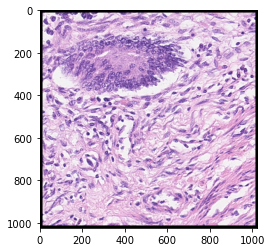

Predicted Mask Sigmoid


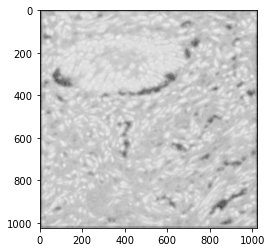

Predicted Mask Binary


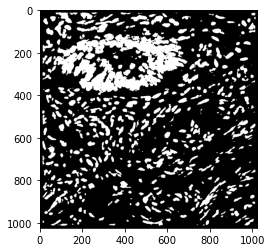

Actual Mask


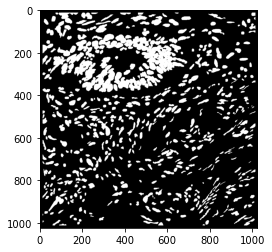

0.6904904161950531 

Batch size: 1, Learning rate: 0.0001 , Epochs: 40



  2%|▎         | 1/40 [00:07<04:49,  7.43s/it]

Train Epoch: 1 @ 15:29:33.471168 - Train Loss: 0.6984


  5%|▌         | 2/40 [00:15<04:44,  7.48s/it]

Train Epoch: 2 @ 15:29:41.071885 - Train Loss: 0.5449


  8%|▊         | 3/40 [00:22<04:36,  7.48s/it]

Train Epoch: 3 @ 15:29:48.555640 - Train Loss: 0.4060


 10%|█         | 4/40 [00:29<04:28,  7.47s/it]

Train Epoch: 4 @ 15:29:56.000842 - Train Loss: 0.3485


 12%|█▎        | 5/40 [00:37<04:21,  7.46s/it]

Train Epoch: 5 @ 15:30:03.436760 - Train Loss: 0.3141


 15%|█▌        | 6/40 [00:44<04:13,  7.45s/it]

Train Epoch: 6 @ 15:30:10.858848 - Train Loss: 0.2992


 18%|█▊        | 7/40 [00:52<04:05,  7.45s/it]

Train Epoch: 7 @ 15:30:18.299205 - Train Loss: 0.2804


 20%|██        | 8/40 [00:59<03:59,  7.47s/it]

Train Epoch: 8 @ 15:30:25.820641 - Train Loss: 0.2652


 22%|██▎       | 9/40 [01:07<03:51,  7.46s/it]

Train Epoch: 9 @ 15:30:33.266779 - Train Loss: 0.2518


 25%|██▌       | 10/40 [01:14<03:43,  7.45s/it]

Train Epoch: 10 @ 15:30:40.695089 - Train Loss: 0.2522


 28%|██▊       | 11/40 [01:22<03:35,  7.43s/it]

Train Epoch: 11 @ 15:30:48.083776 - Train Loss: 0.2375


 30%|███       | 12/40 [01:29<03:28,  7.44s/it]

Train Epoch: 12 @ 15:30:55.552507 - Train Loss: 0.2363


 32%|███▎      | 13/40 [01:37<03:22,  7.50s/it]

Train Epoch: 13 @ 15:31:03.184707 - Train Loss: 0.2255


 35%|███▌      | 14/40 [01:44<03:14,  7.49s/it]

Train Epoch: 14 @ 15:31:10.656336 - Train Loss: 0.2233


 38%|███▊      | 15/40 [01:52<03:07,  7.50s/it]

Train Epoch: 15 @ 15:31:18.159877 - Train Loss: 0.2161


 40%|████      | 16/40 [01:59<02:59,  7.48s/it]

Train Epoch: 16 @ 15:31:25.615672 - Train Loss: 0.2193


 42%|████▎     | 17/40 [02:06<02:51,  7.46s/it]

Train Epoch: 17 @ 15:31:33.025484 - Train Loss: 0.2087


 45%|████▌     | 18/40 [02:14<02:44,  7.48s/it]

Train Epoch: 18 @ 15:31:40.563160 - Train Loss: 0.2083


 48%|████▊     | 19/40 [02:21<02:36,  7.47s/it]

Train Epoch: 19 @ 15:31:47.988724 - Train Loss: 0.2019


 50%|█████     | 20/40 [02:29<02:29,  7.46s/it]

Train Epoch: 20 @ 15:31:55.429007 - Train Loss: 0.2071


 52%|█████▎    | 21/40 [02:36<02:21,  7.45s/it]

Train Epoch: 21 @ 15:32:02.860023 - Train Loss: 0.1953


 55%|█████▌    | 22/40 [02:44<02:14,  7.47s/it]

Train Epoch: 22 @ 15:32:10.379343 - Train Loss: 0.1955


 57%|█████▊    | 23/40 [02:51<02:07,  7.49s/it]

Train Epoch: 23 @ 15:32:17.898244 - Train Loss: 0.1941


 60%|██████    | 24/40 [02:59<01:59,  7.49s/it]

Train Epoch: 24 @ 15:32:25.386616 - Train Loss: 0.2013


 62%|██████▎   | 25/40 [03:06<01:52,  7.48s/it]

Train Epoch: 25 @ 15:32:32.843215 - Train Loss: 0.1894


 65%|██████▌   | 26/40 [03:14<01:44,  7.47s/it]

Train Epoch: 26 @ 15:32:40.285438 - Train Loss: 0.1829


 68%|██████▊   | 27/40 [03:21<01:36,  7.46s/it]

Train Epoch: 27 @ 15:32:47.730334 - Train Loss: 0.1801


 70%|███████   | 28/40 [03:29<01:29,  7.46s/it]

Train Epoch: 28 @ 15:32:55.205441 - Train Loss: 0.1749


 72%|███████▎  | 29/40 [03:36<01:22,  7.46s/it]

Train Epoch: 29 @ 15:33:02.651109 - Train Loss: 0.1779


 75%|███████▌  | 30/40 [03:44<01:14,  7.46s/it]

Train Epoch: 30 @ 15:33:10.109660 - Train Loss: 0.1811


 78%|███████▊  | 31/40 [03:51<01:07,  7.45s/it]

Train Epoch: 31 @ 15:33:17.534831 - Train Loss: 0.1887


 80%|████████  | 32/40 [03:58<00:59,  7.44s/it]

Train Epoch: 32 @ 15:33:24.958635 - Train Loss: 0.1715


 82%|████████▎ | 33/40 [04:06<00:52,  7.44s/it]

Train Epoch: 33 @ 15:33:32.411526 - Train Loss: 0.1668


 85%|████████▌ | 34/40 [04:13<00:44,  7.44s/it]

Train Epoch: 34 @ 15:33:39.829479 - Train Loss: 0.1639


 88%|████████▊ | 35/40 [04:21<00:37,  7.44s/it]

Train Epoch: 35 @ 15:33:47.261122 - Train Loss: 0.1680


 90%|█████████ | 36/40 [04:28<00:29,  7.45s/it]

Train Epoch: 36 @ 15:33:54.762160 - Train Loss: 0.1689


 92%|█████████▎| 37/40 [04:36<00:22,  7.44s/it]

Train Epoch: 37 @ 15:34:02.183152 - Train Loss: 0.1679


 95%|█████████▌| 38/40 [04:43<00:14,  7.44s/it]

Train Epoch: 38 @ 15:34:09.617200 - Train Loss: 0.1609


 98%|█████████▊| 39/40 [04:51<00:07,  7.44s/it]

Train Epoch: 39 @ 15:34:17.053076 - Train Loss: 0.1650


100%|██████████| 40/40 [04:58<00:00,  7.46s/it]

Train Epoch: 40 @ 15:34:24.562236 - Train Loss: 0.1659
Input Image


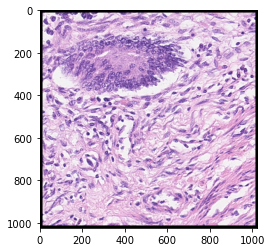

Predicted Mask Sigmoid


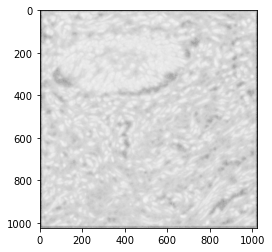

Predicted Mask Binary


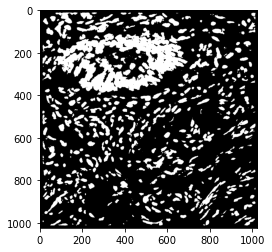

Actual Mask


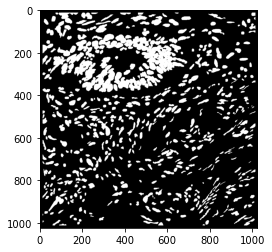

0.6852069562131228 

Batch size: 1, Learning rate: 1e-05 , Epochs: 20



  5%|▌         | 1/20 [00:07<02:23,  7.57s/it]

Train Epoch: 1 @ 15:34:33.677176 - Train Loss: 0.7531


 10%|█         | 2/20 [00:15<02:16,  7.57s/it]

Train Epoch: 2 @ 15:34:41.251001 - Train Loss: 0.7293


 15%|█▌        | 3/20 [00:22<02:08,  7.55s/it]

Train Epoch: 3 @ 15:34:48.736706 - Train Loss: 0.6981


 20%|██        | 4/20 [00:30<02:00,  7.56s/it]

Train Epoch: 4 @ 15:34:56.321282 - Train Loss: 0.6574


 25%|██▌       | 5/20 [00:37<01:53,  7.54s/it]

Train Epoch: 5 @ 15:35:03.803050 - Train Loss: 0.5978


 30%|███       | 6/20 [00:45<01:45,  7.52s/it]

Train Epoch: 6 @ 15:35:11.278510 - Train Loss: 0.5364


 35%|███▌      | 7/20 [00:52<01:37,  7.54s/it]

Train Epoch: 7 @ 15:35:18.860414 - Train Loss: 0.4889


 40%|████      | 8/20 [01:00<01:30,  7.52s/it]

Train Epoch: 8 @ 15:35:26.345064 - Train Loss: 0.4580


 45%|████▌     | 9/20 [01:07<01:22,  7.52s/it]

Train Epoch: 9 @ 15:35:33.852861 - Train Loss: 0.4381


 50%|█████     | 10/20 [01:15<01:15,  7.51s/it]

Train Epoch: 10 @ 15:35:41.357440 - Train Loss: 0.4232


 55%|█████▌    | 11/20 [01:22<01:07,  7.50s/it]

Train Epoch: 11 @ 15:35:48.810771 - Train Loss: 0.4102


 60%|██████    | 12/20 [01:30<00:59,  7.49s/it]

Train Epoch: 12 @ 15:35:56.291722 - Train Loss: 0.3991


 65%|██████▌   | 13/20 [01:37<00:52,  7.49s/it]

Train Epoch: 13 @ 15:36:03.784357 - Train Loss: 0.3891


 70%|███████   | 14/20 [01:45<00:44,  7.50s/it]

Train Epoch: 14 @ 15:36:11.302383 - Train Loss: 0.3799


 75%|███████▌  | 15/20 [01:52<00:37,  7.51s/it]

Train Epoch: 15 @ 15:36:18.842117 - Train Loss: 0.3721


 80%|████████  | 16/20 [02:00<00:30,  7.50s/it]

Train Epoch: 16 @ 15:36:26.329291 - Train Loss: 0.3642


 85%|████████▌ | 17/20 [02:07<00:22,  7.49s/it]

Train Epoch: 17 @ 15:36:33.794238 - Train Loss: 0.3575


 90%|█████████ | 18/20 [02:15<00:15,  7.50s/it]

Train Epoch: 18 @ 15:36:41.322593 - Train Loss: 0.3512


 95%|█████████▌| 19/20 [02:22<00:07,  7.49s/it]

Train Epoch: 19 @ 15:36:48.794408 - Train Loss: 0.3452


100%|██████████| 20/20 [02:30<00:00,  7.51s/it]

Train Epoch: 20 @ 15:36:56.394486 - Train Loss: 0.3390
Input Image


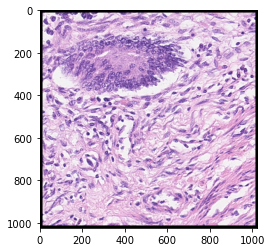

Predicted Mask Sigmoid


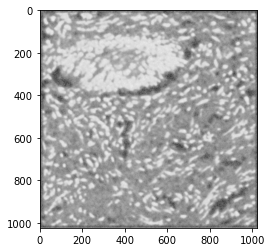

Predicted Mask Binary


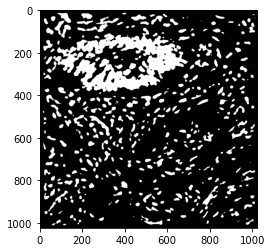

Actual Mask


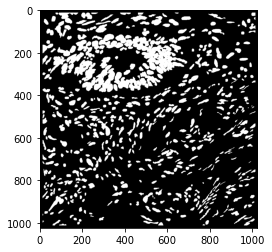

0.6038867195914323 

Batch size: 1, Learning rate: 1e-05 , Epochs: 30



  3%|▎         | 1/30 [00:07<03:33,  7.37s/it]

Train Epoch: 1 @ 15:37:05.096357 - Train Loss: 0.7472


  7%|▋         | 2/30 [00:14<03:26,  7.37s/it]

Train Epoch: 2 @ 15:37:12.451547 - Train Loss: 0.7294


 10%|█         | 3/30 [00:22<03:18,  7.35s/it]

Train Epoch: 3 @ 15:37:19.770478 - Train Loss: 0.7090


 13%|█▎        | 4/30 [00:29<03:10,  7.34s/it]

Train Epoch: 4 @ 15:37:27.089794 - Train Loss: 0.6860


 17%|█▋        | 5/30 [00:36<03:03,  7.34s/it]

Train Epoch: 5 @ 15:37:34.408002 - Train Loss: 0.6505


 20%|██        | 6/30 [00:43<02:55,  7.33s/it]

Train Epoch: 6 @ 15:37:41.717396 - Train Loss: 0.5985


 23%|██▎       | 7/30 [00:51<02:48,  7.34s/it]

Train Epoch: 7 @ 15:37:49.071168 - Train Loss: 0.5444


 27%|██▋       | 8/30 [00:58<02:41,  7.33s/it]

Train Epoch: 8 @ 15:37:56.404111 - Train Loss: 0.4961


 30%|███       | 9/30 [01:06<02:34,  7.35s/it]

Train Epoch: 9 @ 15:38:03.775182 - Train Loss: 0.4583


 33%|███▎      | 10/30 [01:13<02:26,  7.35s/it]

Train Epoch: 10 @ 15:38:11.121803 - Train Loss: 0.4312


 37%|███▋      | 11/30 [01:20<02:19,  7.33s/it]

Train Epoch: 11 @ 15:38:18.410078 - Train Loss: 0.4112


 40%|████      | 12/30 [01:28<02:12,  7.33s/it]

Train Epoch: 12 @ 15:38:25.759446 - Train Loss: 0.3956


 43%|████▎     | 13/30 [01:35<02:04,  7.33s/it]

Train Epoch: 13 @ 15:38:33.064562 - Train Loss: 0.3829


 47%|████▋     | 14/30 [01:42<01:57,  7.33s/it]

Train Epoch: 14 @ 15:38:40.393581 - Train Loss: 0.3723


 50%|█████     | 15/30 [01:50<01:50,  7.34s/it]

Train Epoch: 15 @ 15:38:47.748330 - Train Loss: 0.3633


 53%|█████▎    | 16/30 [01:57<01:42,  7.35s/it]

Train Epoch: 16 @ 15:38:55.127602 - Train Loss: 0.3555


 57%|█████▋    | 17/30 [02:04<01:35,  7.34s/it]

Train Epoch: 17 @ 15:39:02.460972 - Train Loss: 0.3486


 60%|██████    | 18/30 [02:12<01:28,  7.36s/it]

Train Epoch: 18 @ 15:39:09.872856 - Train Loss: 0.3423


 63%|██████▎   | 19/30 [02:19<01:21,  7.38s/it]

Train Epoch: 19 @ 15:39:17.292681 - Train Loss: 0.3365


 67%|██████▋   | 20/30 [02:26<01:13,  7.39s/it]

Train Epoch: 20 @ 15:39:24.694863 - Train Loss: 0.3316


 70%|███████   | 21/30 [02:34<01:06,  7.39s/it]

Train Epoch: 21 @ 15:39:32.089530 - Train Loss: 0.3265


 73%|███████▎  | 22/30 [02:41<00:58,  7.37s/it]

Train Epoch: 22 @ 15:39:39.418331 - Train Loss: 0.3224


 77%|███████▋  | 23/30 [02:49<00:51,  7.37s/it]

Train Epoch: 23 @ 15:39:46.774690 - Train Loss: 0.3185


 80%|████████  | 24/30 [02:56<00:44,  7.35s/it]

Train Epoch: 24 @ 15:39:54.100283 - Train Loss: 0.3154


 83%|████████▎ | 25/30 [03:03<00:36,  7.36s/it]

Train Epoch: 25 @ 15:40:01.457402 - Train Loss: 0.3110


 87%|████████▋ | 26/30 [03:11<00:29,  7.36s/it]

Train Epoch: 26 @ 15:40:08.830904 - Train Loss: 0.3077


 90%|█████████ | 27/30 [03:18<00:22,  7.36s/it]

Train Epoch: 27 @ 15:40:16.185741 - Train Loss: 0.3044


 93%|█████████▎| 28/30 [03:25<00:14,  7.36s/it]

Train Epoch: 28 @ 15:40:23.537090 - Train Loss: 0.3013


 97%|█████████▋| 29/30 [03:33<00:07,  7.34s/it]

Train Epoch: 29 @ 15:40:30.837962 - Train Loss: 0.2984


100%|██████████| 30/30 [03:40<00:00,  7.35s/it]

Train Epoch: 30 @ 15:40:38.168075 - Train Loss: 0.2956
Input Image


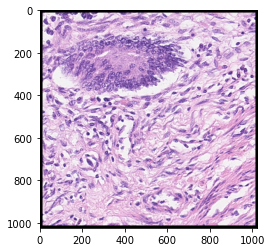

Predicted Mask Sigmoid


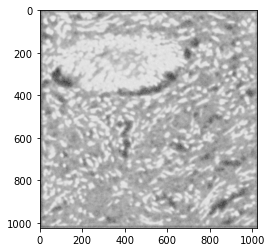

Predicted Mask Binary


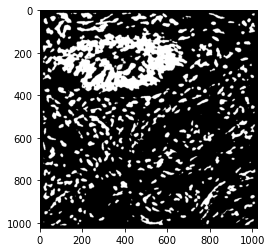

Actual Mask


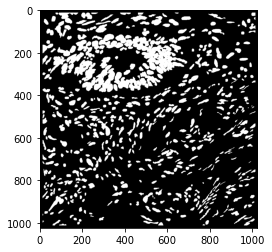

0.6279058420843248 

Batch size: 1, Learning rate: 1e-05 , Epochs: 40



  2%|▎         | 1/40 [00:07<04:54,  7.54s/it]

Train Epoch: 1 @ 15:40:47.081379 - Train Loss: 0.7562


  5%|▌         | 2/40 [00:15<04:49,  7.62s/it]

Train Epoch: 2 @ 15:40:54.897084 - Train Loss: 0.7336


  8%|▊         | 3/40 [00:22<04:41,  7.60s/it]

Train Epoch: 3 @ 15:41:02.452675 - Train Loss: 0.7060


 10%|█         | 4/40 [00:30<04:32,  7.56s/it]

Train Epoch: 4 @ 15:41:09.928203 - Train Loss: 0.6748


 12%|█▎        | 5/40 [00:37<04:23,  7.54s/it]

Train Epoch: 5 @ 15:41:17.418939 - Train Loss: 0.6260


 15%|█▌        | 6/40 [00:45<04:15,  7.51s/it]

Train Epoch: 6 @ 15:41:24.859831 - Train Loss: 0.5671


 18%|█▊        | 7/40 [00:52<04:07,  7.51s/it]

Train Epoch: 7 @ 15:41:32.367573 - Train Loss: 0.5132


 20%|██        | 8/40 [01:00<03:59,  7.48s/it]

Train Epoch: 8 @ 15:41:39.765208 - Train Loss: 0.4683


 22%|██▎       | 9/40 [01:07<03:51,  7.46s/it]

Train Epoch: 9 @ 15:41:47.181303 - Train Loss: 0.4375


 25%|██▌       | 10/40 [01:15<03:43,  7.44s/it]

Train Epoch: 10 @ 15:41:54.569629 - Train Loss: 0.4169


 28%|██▊       | 11/40 [01:22<03:35,  7.43s/it]

Train Epoch: 11 @ 15:42:01.993353 - Train Loss: 0.4016


 30%|███       | 12/40 [01:29<03:27,  7.42s/it]

Train Epoch: 12 @ 15:42:09.393259 - Train Loss: 0.3906


 32%|███▎      | 13/40 [01:37<03:20,  7.42s/it]

Train Epoch: 13 @ 15:42:16.818406 - Train Loss: 0.3812


 35%|███▌      | 14/40 [01:44<03:12,  7.42s/it]

Train Epoch: 14 @ 15:42:24.223678 - Train Loss: 0.3730


 38%|███▊      | 15/40 [01:52<03:06,  7.44s/it]

Train Epoch: 15 @ 15:42:31.730949 - Train Loss: 0.3664


 40%|████      | 16/40 [01:59<02:59,  7.47s/it]

Train Epoch: 16 @ 15:42:39.243672 - Train Loss: 0.3598


 42%|████▎     | 17/40 [02:07<02:52,  7.49s/it]

Train Epoch: 17 @ 15:42:46.786387 - Train Loss: 0.3542


 45%|████▌     | 18/40 [02:14<02:45,  7.50s/it]

Train Epoch: 18 @ 15:42:54.320312 - Train Loss: 0.3485


 48%|████▊     | 19/40 [02:22<02:37,  7.49s/it]

Train Epoch: 19 @ 15:43:01.790543 - Train Loss: 0.3434


 50%|█████     | 20/40 [02:29<02:29,  7.46s/it]

Train Epoch: 20 @ 15:43:09.171581 - Train Loss: 0.3385


 52%|█████▎    | 21/40 [02:37<02:22,  7.51s/it]

Train Epoch: 21 @ 15:43:16.790390 - Train Loss: 0.3339


 55%|█████▌    | 22/40 [02:44<02:15,  7.50s/it]

Train Epoch: 22 @ 15:43:24.285375 - Train Loss: 0.3297


 57%|█████▊    | 23/40 [02:52<02:07,  7.53s/it]

Train Epoch: 23 @ 15:43:31.874043 - Train Loss: 0.3253


 60%|██████    | 24/40 [02:59<02:00,  7.54s/it]

Train Epoch: 24 @ 15:43:39.429045 - Train Loss: 0.3217


 62%|██████▎   | 25/40 [03:07<01:53,  7.54s/it]

Train Epoch: 25 @ 15:43:46.972725 - Train Loss: 0.3182


 65%|██████▌   | 26/40 [03:14<01:45,  7.51s/it]

Train Epoch: 26 @ 15:43:54.421675 - Train Loss: 0.3146


 68%|██████▊   | 27/40 [03:22<01:37,  7.50s/it]

Train Epoch: 27 @ 15:44:01.904002 - Train Loss: 0.3117


 70%|███████   | 28/40 [03:29<01:29,  7.47s/it]

Train Epoch: 28 @ 15:44:09.291815 - Train Loss: 0.3095


 72%|███████▎  | 29/40 [03:37<01:22,  7.46s/it]

Train Epoch: 29 @ 15:44:16.735620 - Train Loss: 0.3061


 75%|███████▌  | 30/40 [03:44<01:14,  7.46s/it]

Train Epoch: 30 @ 15:44:24.184295 - Train Loss: 0.3034


 78%|███████▊  | 31/40 [03:52<01:06,  7.44s/it]

Train Epoch: 31 @ 15:44:31.577622 - Train Loss: 0.3009


 80%|████████  | 32/40 [03:59<00:59,  7.45s/it]

Train Epoch: 32 @ 15:44:39.051467 - Train Loss: 0.2986


 82%|████████▎ | 33/40 [04:06<00:52,  7.44s/it]

Train Epoch: 33 @ 15:44:46.466225 - Train Loss: 0.2962


 85%|████████▌ | 34/40 [04:14<00:44,  7.45s/it]

Train Epoch: 34 @ 15:44:53.933322 - Train Loss: 0.2943


 88%|████████▊ | 35/40 [04:21<00:37,  7.45s/it]

Train Epoch: 35 @ 15:45:01.396747 - Train Loss: 0.2923


 90%|█████████ | 36/40 [04:29<00:29,  7.44s/it]

Train Epoch: 36 @ 15:45:08.794973 - Train Loss: 0.2901


 92%|█████████▎| 37/40 [04:36<00:22,  7.44s/it]

Train Epoch: 37 @ 15:45:16.236501 - Train Loss: 0.2874


 95%|█████████▌| 38/40 [04:44<00:14,  7.43s/it]

Train Epoch: 38 @ 15:45:23.656075 - Train Loss: 0.2854


 98%|█████████▊| 39/40 [04:51<00:07,  7.45s/it]

Train Epoch: 39 @ 15:45:31.136970 - Train Loss: 0.2834


100%|██████████| 40/40 [04:59<00:00,  7.48s/it]

Train Epoch: 40 @ 15:45:38.545914 - Train Loss: 0.2814
Input Image


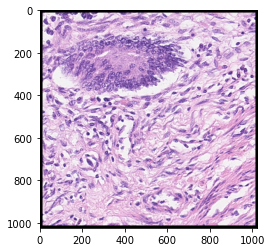

Predicted Mask Sigmoid


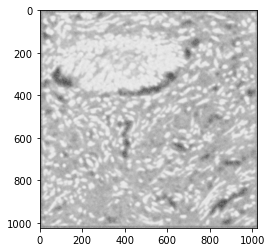

Predicted Mask Binary


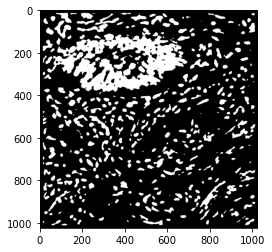

Actual Mask


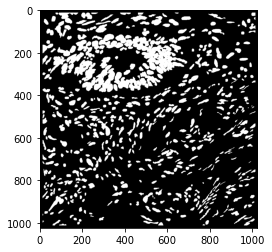

0.6343169185909232 



In [7]:
n_bs = [1]
n_epochs = [20, 30, 40]
n_lr = [0.001, 0.0001, 0.00001]

for bs in n_bs:
    for lr in n_lr:
        for epochs in n_epochs:
            hyperparam_tuning(bs, lr, epochs)